In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.callbacks import Callback
import pandas as pd
import pickle 

In [2]:
file_path = 'D:/bla bla/exported_dataset_New.xlsx'
df = pd.read_excel(file_path)

In [3]:
# Prepare features (X) and labels (Y)
X = df.drop(['Max Rising Slope', 'Soak Time', 'Reflow Time', 'Peak Temp'], axis=1)  # Drop target columns from features
Y = df[['Soak Time']]  # Multi-output labels

In [4]:
# Initialize MinMaxScaler
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

In [5]:
# Scale the features and labels
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

In [6]:
with open('scaler_Y.pkl', 'wb') as f:
    pickle.dump(scaler_Y, f)

In [6]:
# Split the dataset into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.1, random_state=42)

In [7]:
# Define the custom callback to track R² score
class R2ScoreCallback(Callback):
    def __init__(self, X_val, Y_val):
        self.X_val = X_val
        self.Y_val = Y_val
        self.r2_scores = []

    def on_epoch_end(self, epoch, logs=None):
        predictions = self.model.predict(self.X_val)  # Predict on validation set
        predictions = scaler_Y.inverse_transform(predictions)  # Inverse transform predictions
        Y_val_original = scaler_Y.inverse_transform(self.Y_val)  # Inverse transform actual values
        r2 = r2_score(Y_val_original, predictions)  # Calculate R² score
        self.r2_scores.append(r2)  # Save R² score
        print(f"Epoch {epoch+1}: R² score = {r2}")

In [8]:
# Instantiate the R² score callback
r2_callback = R2ScoreCallback(X_test, Y_test)

In [9]:
model = Sequential()

# Layer 0: 896 units, Tanh activation, 0.2 dropout
model.add(Dense(896, activation='tanh', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))

# Layer 1: 128 units, Tanh activation, 0.1 dropout
model.add(Dense(128, activation='tanh'))
model.add(Dropout(0.1))

# Layer 2: 960 units, ReLU activation, 0.2 dropout
model.add(Dense(960, activation='relu'))
model.add(Dropout(0.2))

# Output layer for regression (1 output unit)
model.add(Dense(1))

In [10]:
# Compile the model with Adam optimizer and the specified learning rate
optimizer = Adam(learning_rate=0.001069919146409043)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [11]:
# Train the model and track history and R² score
history = model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test),callbacks=[r2_callback])

Epoch 1/100

1/1 [==============================] - 0s 129ms/steps: 0.27
Epoch 1: R² score = -0.6305662994779906
5/5 [==============================] - 2s 132ms/step - loss: 0.1016 - val_loss: 0.0280
Epoch 2/100
1/1 [==============================] - 0s 31ms/stepss: 0.04
Epoch 2: R² score = 0.07099041497143388
5/5 [==============================] - 0s 43ms/step - loss: 0.0386 - val_loss: 0.0159
Epoch 3/100
1/1 [==============================] - 0s 31ms/stepss: 0.01
Epoch 3: R² score = -0.5140336818593993
5/5 [==============================] - 0s 49ms/step - loss: 0.0272 - val_loss: 0.0260
Epoch 4/100
1/1 [==============================] - 0s 32ms/stepss: 0.03
Epoch 4: R² score = 0.19915779330307903
5/5 [==============================] - 0s 46ms/step - loss: 0.0290 - val_loss: 0.0137
Epoch 5/100
1/1 [==============================] - 0s 31ms/stepss: 0.02
Epoch 5: R² score = 0.24493071527660992
5/5 [==============================] - 0s 50ms/step - loss: 0.0277 - val_loss: 0.0130
Epoch 6/

In [12]:
# Evaluate the model on the test set
loss = model.evaluate(X_test, Y_test)
print(f'Test loss: {loss}')

1/1 [==============================] - 0s 46ms/step - loss: 0.0082
Test loss: 0.008247613906860352


In [13]:
# Make predictions on the test set
predictions_scaled = model.predict(X_test)

1/1 [==============================] - 0s 24ms/step


In [14]:
# Inverse transform the predictions and actual values to get them back to the original scale
predictions = scaler_Y.inverse_transform(predictions_scaled)
Y_test_original = scaler_Y.inverse_transform(Y_test)

In [15]:
# Print a few predictions and actual values in their original (unscaled) form
for i in range(20):
    print(f"Predicted: {predictions[i]}, Actual: {Y_test_original[i]}")

Predicted: [88.567665], Actual: [87.74]
Predicted: [88.05363], Actual: [76.11]
Predicted: [48.75015], Actual: [48.09]
Predicted: [94.72722], Actual: [97.48]
Predicted: [78.194496], Actual: [77.99]
Predicted: [88.86354], Actual: [81.17]
Predicted: [88.86413], Actual: [81.1]
Predicted: [92.35261], Actual: [72.97]
Predicted: [83.24575], Actual: [84.81]
Predicted: [83.62404], Actual: [87.74]
Predicted: [100.474304], Actual: [98.17]
Predicted: [96.80686], Actual: [100.88]
Predicted: [83.5142], Actual: [72.42]
Predicted: [82.86348], Actual: [83.41]
Predicted: [95.10897], Actual: [85.22]
Predicted: [81.31493], Actual: [82.66]
Predicted: [97.91797], Actual: [87.75]
Predicted: [99.41111], Actual: [104.77]
Predicted: [92.83176], Actual: [71.54]
Predicted: [88.17745], Actual: [91.82]


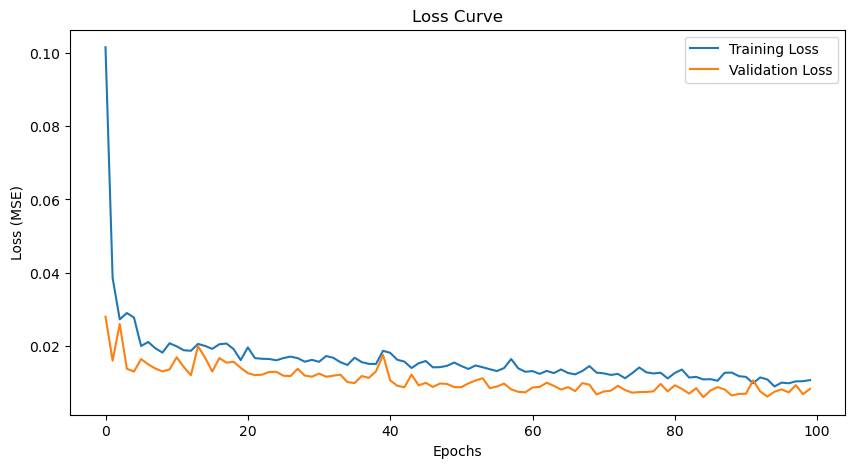

In [16]:
# Plot the loss curve (training and validation)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

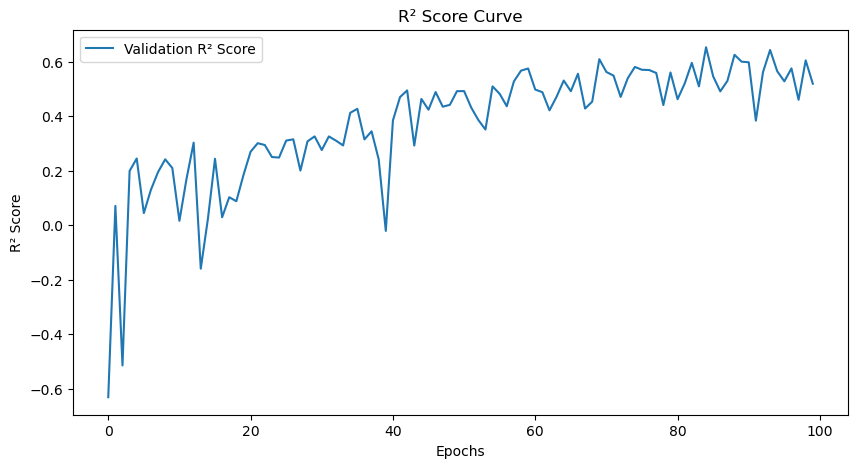

In [17]:
# Plot the R² score curve for validation set
plt.figure(figsize=(10, 5))
plt.plot(r2_callback.r2_scores, label='Validation R² Score')
plt.title('R² Score Curve')
plt.xlabel('Epochs')
plt.ylabel('R² Score')
plt.legend()
plt.show()

In [18]:
# Save the trained model to a file
model_save_path = 'D:/aaaaaa/Soak_Time.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to D:/aaaaaa/Soak_Time.h5


d:\Installation\Anacondaa\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
